In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp pascal_detection

# Pascal Darknet Detection
> Performing bounding box detection on PASCAL VOC 2007 using Darknet

In [ ]:
#| export
from minai import *

import torch
import torch.nn as nn
from torch import tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision.transforms.v2.functional as TF
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms import v2

from torcheval.metrics import MulticlassAccuracy

import fastcore.all as fc
from fastcore.utils import L
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from datasets import load_dataset, load_dataset_builder

from IPython.display import display, Image

from pilus_project.core import *
from pilus_project.darknet import *
from pilus_project.pascal_class import *

## Data

### Data loading

In [ ]:
set_seed(42)

In [ ]:
data_path = fc.Path.home()/'data/'
data_path.ls()

(#3) [Path('/home/kappa/data/VOCtrainval_06-Nov-2007.tar'),Path('/home/kappa/data/VOCdevkit'),Path('/home/kappa/data/pili')]

In [ ]:
trn_ds, val_ds = create_voc_datasets(data_path)
trn_ds

Dataset VOCDetection
    Number of datapoints: 2501
    Root location: /home/kappa/data
    StandardTransform
Transform: Compose(
                 RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

In [ ]:
ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False, )
#     target_transform=voc_extract(field='bndbox'))
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000012.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '207539885'},
   'owner': {'flickrid': 'KevBow', 'name': '?'},
   'size': {'width': '500', 'height': '333', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'car',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}})

## Dataset

In [ ]:
# to_tensor = v2.Compose([
#     v2.Resize((224, 224)),
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [ ]:
# trn_ds = datasets.VOCDetection(
#     root=data_path, year="2007", image_set='train', download=False, 
#     transform=to_tensor)
# val_ds = datasets.VOCDetection(
#     root=data_path, year="2007", image_set='val', download=False, 
#     transform=to_tensor)

In [ ]:
# bs = 64

# trn_dl, val_dl = get_dls(trn_ds, val_ds, bs=bs)
# xb,yb = next(iter(trn_dl))
# xb.shape,yb[:10]

### Extract Bounding Box Information

In [ ]:
def voc_extract_detection(targ, clss=VOC_CLASSES):
    "Extract class names and bounding boxes from VOC annotations"
    objects = fc.nested_attr(targ, 'annotation.object')
    if not objects: return [], []
    
    boxes = []
    labels = []
    for obj in objects:
        name = obj['name']
        if name in clss:
            bbox = obj['bndbox']
            x1, y1 = float(bbox['xmin']), float(bbox['ymin'])
            x2, y2 = float(bbox['xmax']), float(bbox['ymax'])
            boxes.append([x1, y1, x2, y2])
            labels.append(clss.index(name))
    
    return torch.tensor(boxes), torch.tensor(labels)

In [ ]:
sample_img, sample_target = ds[0]
boxes, labels = voc_extract_detection(sample_target)
boxes, labels

(tensor([[156.,  97., 351., 270.]]), tensor([6]))

(-0.5, 499.5, 332.5, -0.5)

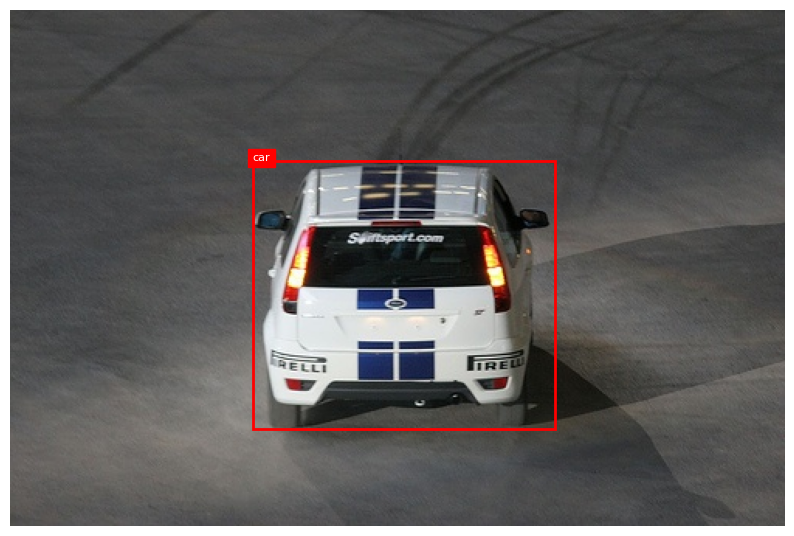

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(sample_img)
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = box.tolist()
    class_name = VOC_CLASSES[label]
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
plt.axis('off')

### Create a Detection Dataset

In [ ]:
class VOCDetectionDataset(Dataset):
    "Dataset for VOC object detection"
    def __init__(self, voc_ds, transforms=None):
        self.voc_ds = voc_ds
        self.transforms = transforms
        
    def __len__(self): return len(self.voc_ds)
    
    def __getitem__(self, idx):
        img, target = self.voc_ds[idx]
        boxes, labels = voc_extract_detection(target)
        
        # Handle empty boxes
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        
        target = {"boxes": boxes, "labels": labels}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target

Sample target: {'boxes': tensor([[156.,  97., 351., 270.]]), 'labels': tensor([6])}


(-0.5, 499.5, 332.5, -0.5)

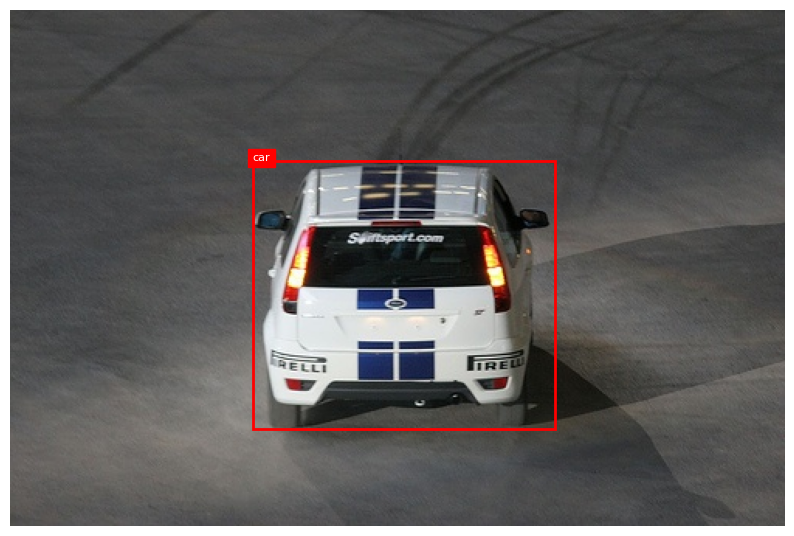

In [ ]:
# Create raw dataset
raw_ds = datasets.VOCDetection(root=data_path, year='2007', image_set='train', download=False)

# Create detection dataset
detection_ds = VOCDetectionDataset(raw_ds)

# Test with a sample
sample_img, sample_target = detection_ds[0]
print(f"Sample target: {sample_target}")

# Display the image with boxes
plt.figure(figsize=(10, 8))
plt.imshow(sample_img)
for box, label in zip(sample_target['boxes'], sample_target['labels']):
    x1, y1, x2, y2 = box.tolist()
    class_name = VOC_CLASSES[label]
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
plt.axis('off')

### Create Transforms for Detection

In [ ]:
def get_detection_transforms(train=True):
    "Create transforms that correctly handle both images and bounding boxes"
    transforms_list = []
    
    # Convert PIL image to tensor and normalize
    transforms_list.extend([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ])
    
    if train:
        # Add augmentations for training only
        transforms_list.extend([
            v2.RandomPhotometricDistort(),
            v2.RandomZoomOut(fill=[0, 0, 0]),
            v2.RandomIoUCrop(),
            v2.RandomHorizontalFlip(p=0.5)
        ])
    
    # Add final resize and normalization
    transforms_list.extend([
        v2.Resize((800, 800)),  # Fixed size for simplicity
        v2.Normalize(mean=xmean, std=xstd)
    ])
    
    return v2.Compose(transforms_list)

In [ ]:
def show_boxes_before_after_transform(ds_raw, idx=0):
    "Show how bounding boxes are correctly transformed"
    # Create datasets with transforms
    train_transforms = get_detection_transforms(train=True)
    
    # Get raw sample
    img_raw, target_raw = ds_raw[idx]
    boxes_raw, labels_raw = voc_extract_detection(target_raw)
    
    # Create detection target format
    target_dict = {"boxes": boxes_raw, "labels": labels_raw}
    
    # Apply transforms
    img_transformed, target_transformed = train_transforms(img_raw, target_dict)
    
    # Plot before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Before transform
    ax1.imshow(img_raw)
    ax1.set_title("Before Transform")
    for box, label in zip(boxes_raw, labels_raw):
        x1, y1, x2, y2 = box.tolist()
        class_name = VOC_CLASSES[label]
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
        ax1.add_patch(rect)
        ax1.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
    ax1.axis('off')
    
    # After transform
    img_display = denorm(img_transformed).permute(1, 2, 0).clip(0, 1).cpu().numpy()
    ax2.imshow(img_display)
    ax2.set_title("After Transform")
    for box, label in zip(target_transformed["boxes"], target_transformed["labels"]):
        x1, y1, x2, y2 = box.tolist()
        class_name = VOC_CLASSES[label]
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
        ax2.add_patch(rect)
        ax2.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
    ax2.axis('off')
    
    plt.tight_layout()
    return fig


In [ ]:
class VOCDetectionDataset(Dataset):
    "Dataset for VOC object detection with proper box transforms"
    def __init__(self, voc_ds, transforms=None):
        self.voc_ds = voc_ds
        self.transforms = transforms
        
    def __len__(self): return len(self.voc_ds)
    
    def __getitem__(self, idx):
        img, target = self.voc_ds[idx]
        boxes, labels = voc_extract_detection(target)
        
        # Handle empty boxes
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        
        target = {"boxes": boxes, "labels": labels}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target

In [ ]:
def get_detection_dls(data_path, bs=4, year='2007'):
    "Create dataloaders for object detection with proper transforms"
    # Create raw datasets
    train_ds_raw = datasets.VOCDetection(root=data_path, year=year, image_set='train', download=False)
    valid_ds_raw = datasets.VOCDetection(root=data_path, year=year, image_set='val', download=False)
    
    # Create transforms
    train_transforms = get_detection_transforms(train=True)
    valid_transforms = get_detection_transforms(train=False)
    
    # Create detection datasets
    train_ds = VOCDetectionDataset(train_ds_raw, train_transforms)
    valid_ds = VOCDetectionDataset(valid_ds_raw, valid_transforms)
    
    # Create dataloaders
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, 
                         collate_fn=detection_collate_fn, num_workers=4)
    valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, 
                         collate_fn=detection_collate_fn, num_workers=4)
    
    return DataLoaders(train_dl, valid_dl)

In [ ]:
# Create raw dataset
raw_ds = datasets.VOCDetection(root=data_path, year='2007', image_set='train', download=False)

# Show before and after transforms
show_boxes_before_after_transform(raw_ds, idx=5)

# Create dataloaders with proper transforms
detection_dls = get_detection_dls(data_path)

# Visualize a batch to confirm boxes are aligned
batch_imgs, batch_targets = next(iter(detection_dls.train))
show_detection_batch(batch_imgs, batch_targets)

TypeError: RandomIoUCrop() requires input sample to contain tensor or PIL images and bounding boxes. Sample can also contain masks.

(-0.5, 719.5, 479.5, -0.5)

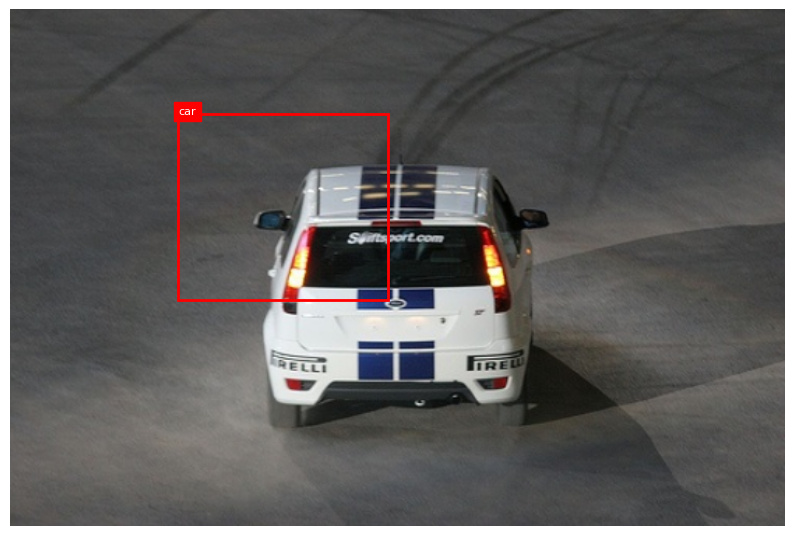

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(denorm(sample_img).permute(1, 2, 0).cpu().numpy())
for box, label in zip(sample_target['boxes'], sample_target['labels']):
    x1, y1, x2, y2 = box.tolist()
    class_name = VOC_CLASSES[label]
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
plt.axis('off')

In [ ]:
def detection_collate_fn(batch):
    "Custom collate function for detection data with variable-sized boxes and labels"
    images = []
    targets = []
    
    for img, targ in batch:
        images.append(img)
        targets.append(targ)
    
    images = torch.stack(images)
    return images, targets

In [ ]:
trn_dl, val_dl = get_detection_dls(data_path, bs=4)
xb, yb = next(iter(trn_dl))
show_detection_batch(xb, yb)

TypeError: 'DataLoader' object is not subscriptable

In [ ]:
def get_detection_dls(data_path, bs=8, year='2007'):
    "Create dataloaders for object detection"
    transforms = get_detection_transforms()
    
    train_ds = datasets.VOCDetection(root=data_path, year=year, image_set='train', download=False, transform=transforms)
    valid_ds = datasets.VOCDetection(root=data_path, year=year, image_set='val', download=False, transform=transforms)
    
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=detection_collate_fn, num_workers=4)
    valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, collate_fn=detection_collate_fn, num_workers=4)
    
    return get_dls(train_dl, valid_dl, bs=bs)

In [ ]:
def show_detection_batch(images, targets, max_n=6, figsize=(15, 10)):
    "Show detection results with bounding boxes"
    n = min(len(images), max_n)
    fig, axs = plt.subplots(1, n, figsize=figsize)
    if n == 1: axs = [axs]
    
    for i in range(n):
        img = denorm(images[i])
        img = img.permute(1, 2, 0).cpu().numpy()
        ax = axs[i]
        ax.imshow(img)
        
        # Draw boxes
        for box, label in zip(targets[i]['boxes'], targets[i]['labels']):
            x1, y1, x2, y2 = box.tolist()
            class_name = VOC_CLASSES[label]
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
        
        ax.axis('off')
    
    plt.tight_layout()
    return fig

In [ ]:
def get_detection_model(num_classes=len(VOC_CLASSES) + 1):  # +1 for background
    "Create object detection model based on darknet19"
    from torchvision.models.detection import FasterRCNN
    from torchvision.models.detection.rpn import AnchorGenerator
    
    # Use darknet19 as backbone
    backbone = get_darknet19()
    
    # Remove the last layer (which is for classification)
    backbone = nn.Sequential(*list(backbone.children())[:-1])
    
    # FasterRCNN needs to know the number of output channels
    backbone.out_channels = 512
    
    # Define anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    
    # Define ROI pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )
    
    # Create the detection model
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )
    
    return model

In [ ]:
detection_dls = get_detection_dls(data_path, bs=4)  # Smaller batch size for detection

# Visualize a batch
xb, yb = next(iter(detection_dls.train))
show_detection_batch(xb, yb)

TypeError: get_dls() missing 1 required positional argument: 'bs'

In [ ]:
# Create detection model
detection_model = get_detection_model()

# Detection models in torchvision handle the loss internally
# So we need a custom learner that doesn't calculate loss separately
class DetectionLearner(Learner):
    def predict(self):
        self.preds = self.model(self.batch[0])
    
    def get_loss(self):
        # Loss is already calculated inside the model during training
        if self.training:
            self.loss = sum(loss for loss in self.preds.values())
        else:
            self.loss = torch.tensor(0.0, device=self.batch[0].device)

# Create learner
learn = DetectionLearner(detection_model, detection_dls, None, lr=0.005,
                       cbs=[DeviceCB(), ProgressCB()])

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/kappa/miniforge3/envs/torch_latest/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/kappa/miniforge3/envs/torch_latest/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_932/2076025865.py", line 10, in detection_collate_fn
    images = torch.stack(images)
             ^^^^^^^^^^^^^^^^^^^
  File "/home/kappa/miniforge3/envs/torch_latest/lib/python3.11/site-packages/torchvision/tv_tensors/_tv_tensor.py", line 77, in __torch_function__
    output = func(*args, **kwargs or dict())
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [3, 697, 480] at entry 0 and [3, 480, 720] at entry 1


### Eval

In [ ]:
# Function to evaluate detection results
def evaluate_detection(model, dataloader, iou_threshold=0.5):
    "Evaluate detection model using mAP"
    from torchvision.ops import box_iou
    
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(def_device)
            predictions = model(images)
            
            # Move predictions to CPU
            for i in range(len(predictions)):
                pred = {k: v.cpu() for k, v in predictions[i].items()}
                all_preds.append(pred)
                all_targets.append(targets[i])
    
    # Calculate mAP
    # This is a simplified version - a full implementation would use the COCO API
    aps = []
    for class_idx in range(len(VOC_CLASSES)):
        precisions = []
        recalls = []
        
        for pred, target in zip(all_preds, all_targets):
            # Get predictions and targets for this class
            pred_boxes = pred['boxes'][pred['labels'] == class_idx]
            pred_scores = pred['scores'][pred['labels'] == class_idx]
            target_boxes = target['boxes'][target['labels'] == class_idx]
            
            if len(target_boxes) == 0:
                continue
                
            if len(pred_boxes) == 0:
                precisions.append(0)
                recalls.append(0)
                continue
            
            # Sort predictions by score
            sorted_idx = torch.argsort(pred_scores, descending=True)
            pred_boxes = pred_boxes[sorted_idx]
            
            # Calculate IoU
            ious = box_iou(pred_boxes, target_boxes)
            
            # Calculate precision and recall
            tp = (ious > iou_threshold).any(dim=1).float()
            fp = 1 - tp
            
            tp_cumsum = torch.cumsum(tp, dim=0)
            fp_cumsum = torch.cumsum(fp, dim=0)
            
            precision = tp_cumsum / (tp_cumsum + fp_cumsum)
            recall = tp_cumsum / len(target_boxes)
            
            precisions.append(precision)
            recalls.append(recall)
        
        # Calculate AP
        if precisions and recalls:
            # Simplified AP calculation
            ap = sum([p * r for p, r in zip(precisions, recalls)]) / len(precisions)
            aps.append(ap)
    
    return sum(aps) / len(aps) if aps else 0

# Evaluate the model
mAP = evaluate_detection(learn.model, detection_dls.valid)
print(f"mAP: {mAP:.4f}")

In [ ]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        padding = 1 if kernel_size == 3 else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)

    def forward(self, x): return self.leaky(self.bn(self.conv(x)))

class Darknet19(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Initial layers
            ConvBlock(3, 32),
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            nn.MaxPool2d(2),
            
            # First block
            ConvBlock(64, 128),
            ConvBlock(128, 64, kernel_size=1),
            ConvBlock(64, 128),
            nn.MaxPool2d(2),
            
            # Second block
            ConvBlock(128, 256),
            ConvBlock(256, 128, kernel_size=1),
            ConvBlock(128, 256),
            nn.MaxPool2d(2),
            
            # Third block
            ConvBlock(256, 512),
            ConvBlock(512, 256, kernel_size=1),
            ConvBlock(256, 512),
            ConvBlock(512, 256, kernel_size=1),
            ConvBlock(256, 512),
            nn.MaxPool2d(2),
            
            # Fourth block
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1),
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1),
            ConvBlock(512, 1024)
        )

    def forward(self, x): return self.features(x)


In [ ]:
class YOLOv2(nn.Module):
    def __init__(self, num_classes, num_anchors=5):
        super().__init__()
        self.backbone = Darknet19()
        
        # Passthrough layer from earlier feature map
        self.passthrough_conv = ConvBlock(512, 64, kernel_size=1)
        
        # Detection head
        self.detection = nn.Sequential(
            ConvBlock(1024 + 256, 1024),  # +256 from passthrough (64*4)
            nn.Conv2d(1024, num_anchors * (5 + num_classes), kernel_size=1)
        )
        
    def reorg_layer(self, x):
        # Reorganize 26x26x64 to 13x13x256
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, height//2, 2, width//2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.contiguous().view(batch_size, channels*4, height//2, width//2)
        return x

    def forward(self, x):
        # Get backbone features
        for i, layer in enumerate(self.backbone.features):
            x = layer(x)
            if i == 13:  # Save feature map for passthrough
                passthrough = self.passthrough_conv(x)
                passthrough = self.reorg_layer(passthrough)
        
        # Concatenate passthrough with final features
        x = torch.cat([passthrough, x], dim=1)
        
        # Detection head
        return self.detection(x)
